Import libraries

In [1]:
import os 
import numpy as np 
from tqdm import tqdm
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt

from utils import load_pickle, pickle_data

Settings

In [2]:
cache_folder = "./cache"
if not os.path.exists(cache_folder): os.makedirs(cache_folder)

Get all the experiments

In [8]:
folders = ["../FP_prediction/mist/models_cached/morgan4_4096", "../FP_prediction/baseline_models/models_cached/morgan4_4096"]
all_experiments = []

for folder in folders:
    for dataset in os.listdir(folder):
        dataset_folder = os.path.join(folder, dataset)
        for model in os.listdir(dataset_folder):
            all_experiments.append(os.path.join(dataset_folder, model))

Helper Functions

In [11]:
folder = "../FP_prediction/baseline_models/models_cached/morgan4_4096"
percent_scores_path = os.path.join(cache_folder, "percent_scores.pkl")
consistent_train_set_across_datasets = {}
splits = ["random"]

for dataset in ["canopus", "massspecgym"]:
    
    rank_path = os.path.join(cache_folder, f"train_ranks_{dataset}.pkl")

    if not os.path.exists(rank_path):

        split_train_ranks = {}
        
        for split in splits: 

            selected_expt = [f for f in all_experiments if split in f and dataset in f]
            assert len(selected_expt) == 4
            consistent_train_set = {} 

            for expt in tqdm(selected_expt): 
                
                consistent_train_set[expt] = {}
                influence_scores_path = os.path.join(expt, "EK-FAC_scores.pkl")
                influence_scores = load_pickle(influence_scores_path)["all_modules"].numpy()
                n_test, n_train = influence_scores.shape

                for test_id in tqdm(range(n_test)):
                    
                    if test_id not in consistent_train_set: consistent_train_set[expt][test_id] = {"helpful": [], "harmful": []}

                    for train_id in range(n_train):

                        s = influence_scores[test_id, train_id]
                        if s < 0: consistent_train_set[expt][test_id]["harmful"].append(train_id)
                        if s > 0: consistent_train_set[expt][test_id]["helpful"].append(train_id)

            # Consolidate the set now 
            train_harmful_count, train_helpful_count = {}, {} 
            consolidated_test = {} 

            for test_id in range(n_test):
                
                consolidated_test[test_id] = {"harmful": None, "helpful": None}

                for expt in consistent_train_set.keys():

                    if consolidated_test[test_id]["harmful"] is None: consolidated_test[test_id]["harmful"] = set(consistent_train_set[expt][test_id]["harmful"])
                    consolidated_test[test_id]["harmful"] = consolidated_test[test_id]["harmful"].intersection(set(consistent_train_set[expt][test_id]["harmful"]))

                    if consolidated_test[test_id]["helpful"] is None: consolidated_test[test_id]["helpful"] = set(consistent_train_set[expt][test_id]["helpful"])
                    consolidated_test[test_id]["helpful"] = consolidated_test[test_id]["helpful"].intersection(set(consistent_train_set[expt][test_id]["helpful"]))

            # Format the data 
            for k, v in consolidated_test.items():

                for train_id in v["helpful"]:
                    if train_id not in train_helpful_count: train_helpful_count[train_id] = 0 
                    train_helpful_count[train_id] += 1 

                for train_id in v["harmful"]:
                    if train_id not in train_harmful_count: train_harmful_count[train_id] = 0 
                    train_harmful_count[train_id] += 1 

            split_train_ranks[split] = {"harmful": train_harmful_count, "helpful": train_helpful_count} 

        pickle_data(split_train_ranks, rank_path)
    
    split_train_ranks = load_pickle(rank_path)
    consistent_train_set_across_datasets[dataset] = split_train_ranks

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:04<?, ?it/s]


KeyboardInterrupt: 

Add the training ids to these records

In [4]:
consistent_train_set_across_datasets_w_id_path = os.path.join(cache_folder, "train_performance_across_model_splits.pkl")

if not os.path.exists(consistent_train_set_across_datasets_w_id_path):

    consistent_train_set_across_datasets_w_id = {} 

    for dataset, consolidated_results in consistent_train_set_across_datasets.items():

        consistent_train_set_across_datasets_w_id[dataset] = {} 

        for split, splits_results in consolidated_results.items():

            current_folder = os.path.join(folder, dataset)
            chosen_model = [f for f in os.listdir(current_folder) if split in f][0]
            train_ids_path = os.path.join(current_folder, chosen_model, "train_ids.pkl")
            train_ids = load_pickle(train_ids_path)

            harmful_results = splits_results["harmful"]
            helpful_results = splits_results["helpful"]

            harmful_results_w_id = {train_ids[k]: v for k,v in harmful_results.items()}
            helpful_results_w_id = {train_ids[k]: v for k,v in helpful_results.items()}

            consistent_train_set_across_datasets_w_id[dataset][split] = {"harmful": harmful_results_w_id,
                                                                        "helpful": helpful_results_w_id}

    pickle_data(consistent_train_set_across_datasets_w_id, consistent_train_set_across_datasets_w_id_path)

consistent_train_set_across_datasets_w_id = load_pickle(consistent_train_set_across_datasets_w_id_path)

In [62]:
consolidated_scores = {}

for dataset, consolidated_results in consistent_train_set_across_datasets_w_id.items():
    
    consolidated_scores[dataset] = {}

    for split, splits_results in consolidated_results.items():
        
        split_scores_harmful = {}
        split_scores_helpful = {}

        harmful_stats = splits_results["harmful"]
        helpful_stats = splits_results["helpful"]

        for train_id, harmful_count in harmful_stats.items():
            
            helpful_count = helpful_stats[train_id]

            train_id = Path(train_id).stem
            split_scores_harmful[train_id] = round(harmful_count / 1000 * 100, 3)
            split_scores_helpful[train_id] = round(helpful_count / 1000 * 100, 3)

        consolidated_scores[dataset][split] = {"harmful": split_scores_harmful, "helpful": split_scores_helpful}

Aggregate across different splits

In [16]:
consistent_train_set_across_datasets_across_splits = {}

for dataset, results in consistent_train_set_across_datasets_w_id.items():
    
    consistent_train_set_across_datasets_across_splits[dataset] = {} 
    n_splits = len(results)

    for split, subresults in results.items():
        
        harmful = subresults["harmful"]
        helpful = subresults["helpful"]

        for train_id, count in harmful.items():

            train_id = Path(train_id).stem
            
            if train_id not in consistent_train_set_across_datasets_across_splits[dataset]: 
                consistent_train_set_across_datasets_across_splits[dataset][train_id] = {}
            if "harmful" not in consistent_train_set_across_datasets_across_splits[dataset][train_id]:
                consistent_train_set_across_datasets_across_splits[dataset][train_id]["harmful"] = {"count":0, "total":0}
            consistent_train_set_across_datasets_across_splits[dataset][train_id]["harmful"]["count"] += count 
            consistent_train_set_across_datasets_across_splits[dataset][train_id]["harmful"]["total"] += 1 


        for train_id, count in helpful.items():

            train_id = Path(train_id).stem
            if train_id not in consistent_train_set_across_datasets_across_splits[dataset]: 
                consistent_train_set_across_datasets_across_splits[dataset][train_id] = {}
            
            if "helpful" not in consistent_train_set_across_datasets_across_splits[dataset][train_id]:
                consistent_train_set_across_datasets_across_splits[dataset][train_id]["helpful"] = {"count":0, "total":0}

            consistent_train_set_across_datasets_across_splits[dataset][train_id]["helpful"]["count"] += count 
            consistent_train_set_across_datasets_across_splits[dataset][train_id]["helpful"]["total"] += 1 

Keep only certain samples

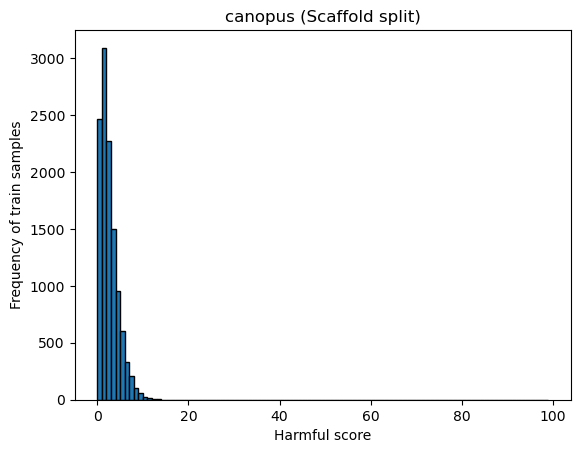

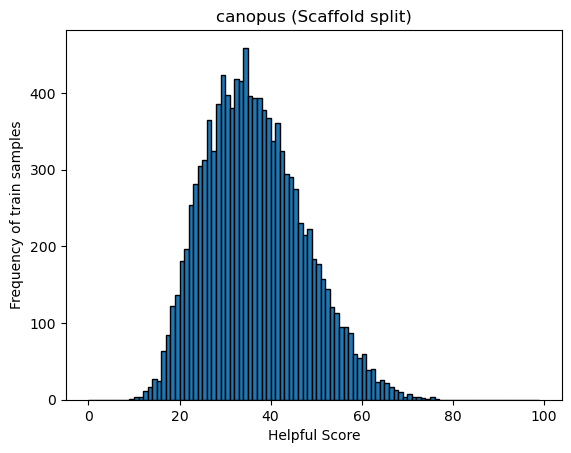

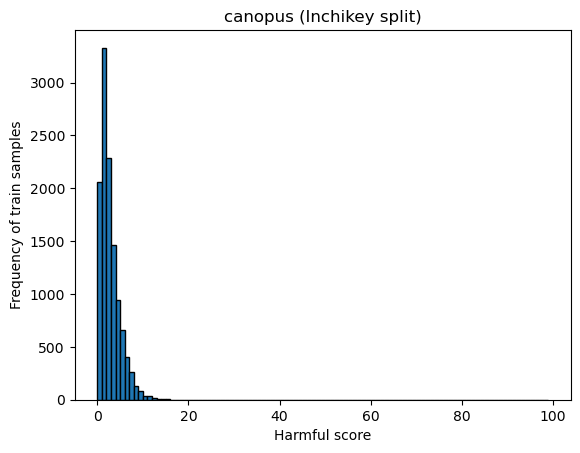

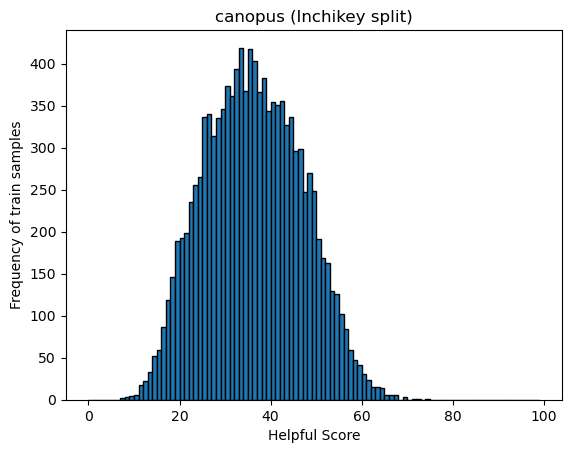

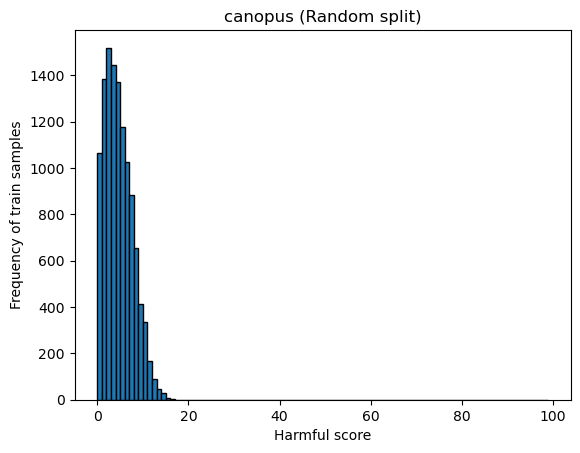

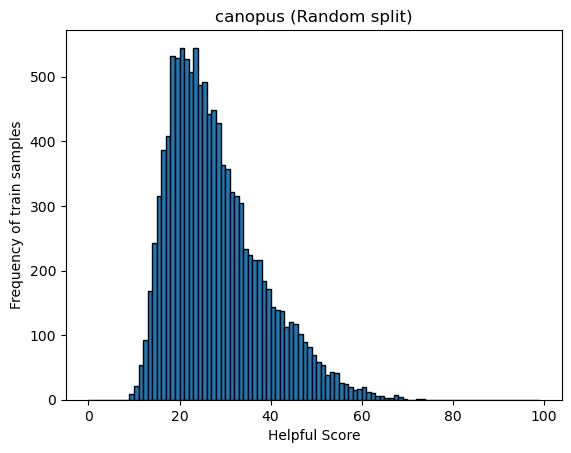

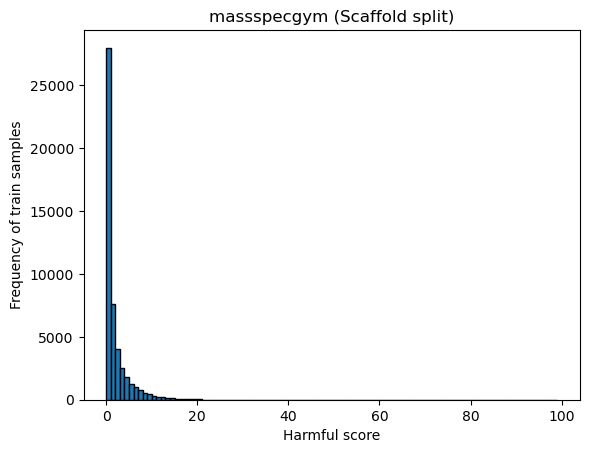

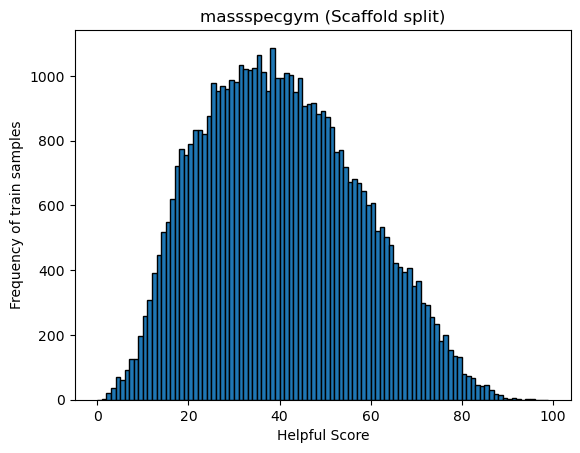

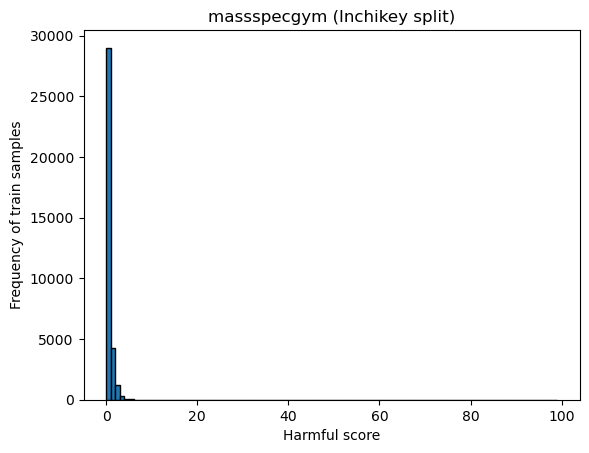

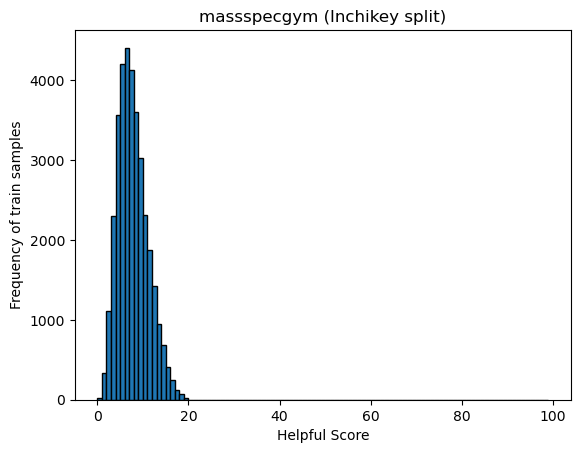

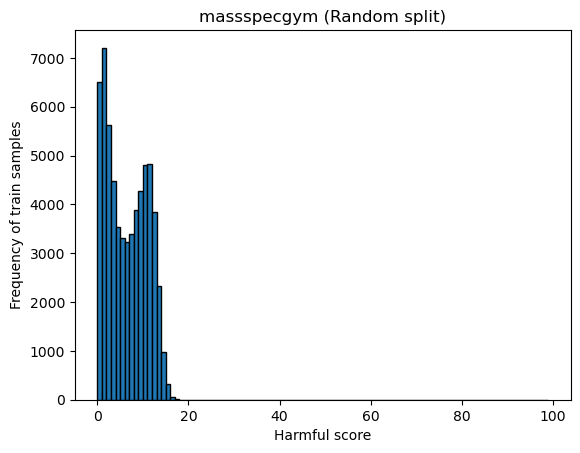

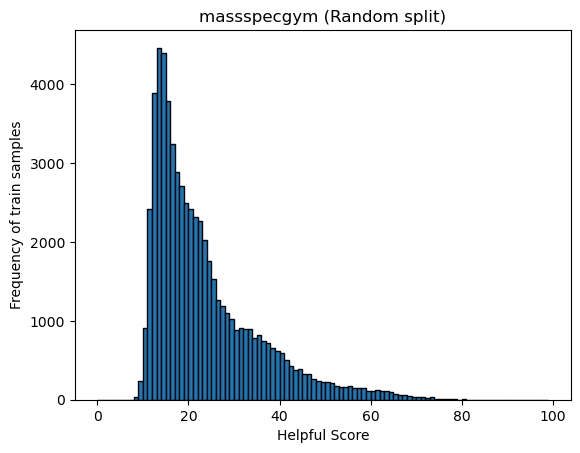

In [66]:
for dataset, results in consolidated_scores.items():

    for split, subresults in results.items():

        helpful = subresults["helpful"]
        harmful = subresults["harmful"]
        if split == "random": splitname = "Random"
        if split == "scaffold_vanilla": splitname = "Scaffold"
        if split == "inchikey_vanilla": splitname = "Inchikey"

        plt.hist([k for k in harmful.values()], bins=range(0, 100), edgecolor='black')
        plt.xlabel('Harmful score')
        plt.ylabel('Frequency of train samples')
        plt.title(f'{dataset} ({splitname} split)')
        plt.show()

        plt.hist([k for k in helpful.values()], bins=range(0, 100), edgecolor='black')
        plt.xlabel('Helpful Score')
        plt.ylabel('Frequency of train samples')
        plt.title(f'{dataset} ({splitname} split)')
        plt.show()

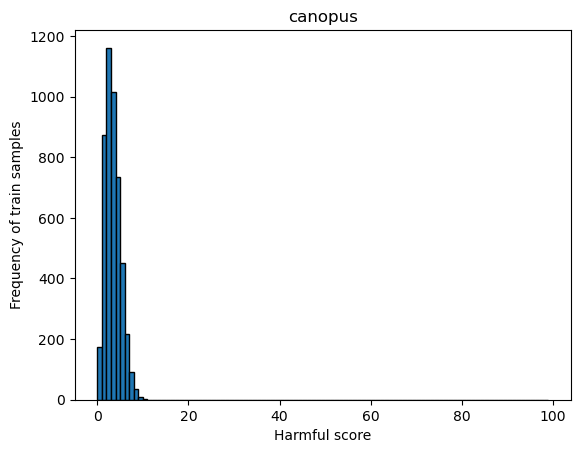

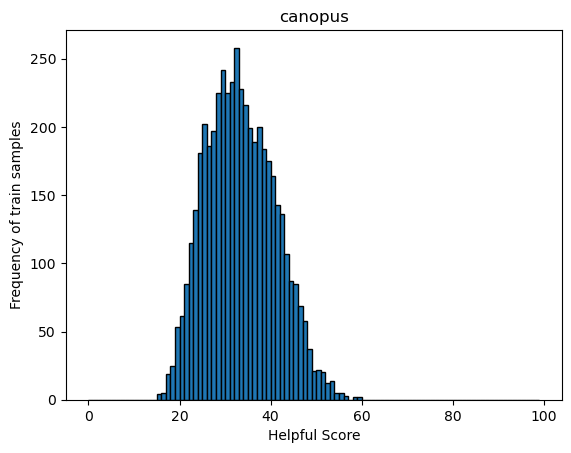

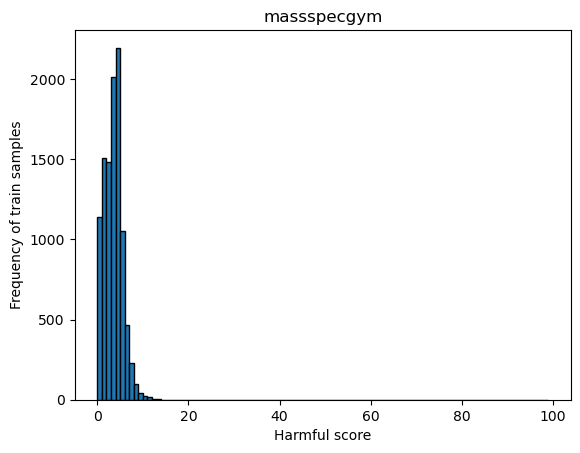

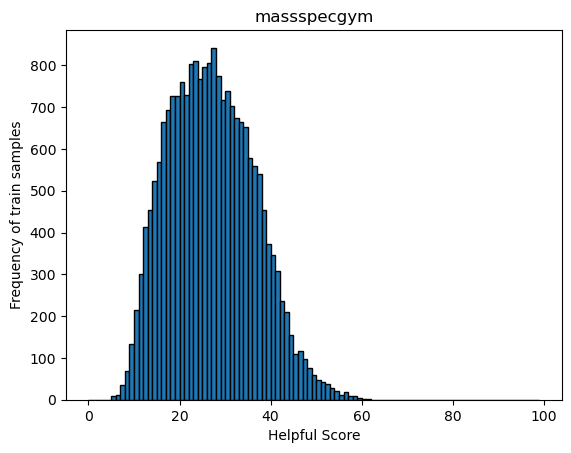

In [56]:
for dataset in ["canopus", "massspecgym"]:

    helpful = {k : v["helpful"] for k,v in consistent_train_set_across_datasets_across_splits[dataset].items() if "helpful" in v}
    harmful = {k : v["harmful"] for k,v in consistent_train_set_across_datasets_across_splits[dataset].items() if "harmful" in v}

    helpful = {k : round(v["count"] / 3000 * 100,3) for k, v in helpful.items() if v["total"] == 3}
    harmful = {k : round(v["count"] / 3000* 100,3) for k, v in harmful.items() if v["total"] == 3}

    plt.hist([k for k in harmful.values()], bins=range(0, 100), edgecolor='black')
    plt.xlabel('Harmful score')
    plt.ylabel('Frequency of train samples')
    plt.title(f'{dataset}')
    plt.show()

    plt.hist([k for k in helpful.values()], bins=range(0, 100), edgecolor='black')
    plt.xlabel('Helpful Score')
    plt.ylabel('Frequency of train samples')
    plt.title(f'{dataset}')
    plt.show()
